In [57]:
from timbr import Snapshot
%reload_ext timbr.notebook

In [6]:
data = Snapshot("/Users/chelm/.timbr/data/Planet Labs Los Angeles (RapidEye with Thumbnails).h5")

./la_images/visual/20160311_191308_1154610_RapidEye-4_visual.tif


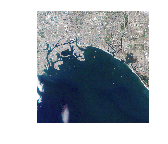

./la_images/visual/20160315_191710_1154610_RapidEye-3_visual.tif


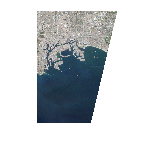

./la_images/visual/20160316_191802_1154610_RapidEye-4_visual.tif


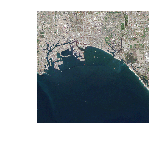

In [198]:
"""
Downloads the n-latest visual or analytic geotifs from Planet Labs
Writes images to a directory used to access them from disk in other snippets 
"""

from planet import api
import sys, os
import urllib2, httplib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class NoRedirection(urllib2.HTTPErrorProcessor):
    def http_response(self, request, response):
        return response
    https_response = http_response


def get_image(scene, scene_type='visual', data_dir="./planet_images"):
    opener = urllib2.build_opener(NoRedirection)
    
    img_dir = os.path.join(data_dir, scene_type)
    if not os.path.exists( img_dir ):
        os.makedirs(img_dir)
        
    url = scene['properties']['data']['products'][scene_type]['full']
    
    filename = os.path.join(img_dir, '%s_%s.tif' % (scene['id'], scene_type)) 
    req = urllib2.Request(url, headers={"Authorization": "api-key %s" % api_key})
    response = opener.open(req)
    
    if 'Location' in response.headers:
        redirect_url = response.headers['Location']
        req = urllib2.Request(redirect_url)
        response = opener.open(req)
    
    CHUNK = 16 * 1024
    total = 0
    with open(filename, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                sys.stdout.flush()
                break
                
            total += CHUNK
            sys.stdout.flush()
            sys.stdout.write('\r>> Downloading %s %d' % (filename, total))
            f.write(chunk)
            


api_key = "65a347d4358348189a800a5eac3bcde7"

def download_latest(data, amount=2, data_dir="./planet_images", scene_type="visual"):
    ids, rows = zip(*data)
    sorted_scenes = sorted(rows, key=lambda k: k['properties']['acquired']) 
    
    for scene in sorted_scenes[-amount:]:
        filename = os.path.join(data_dir, scene_type, scene['id'] + '_' + scene_type + '.tif')
        if not os.path.exists(filename):
            get_image(scene, scene_type=scene_type, data_dir=data_dir)        
        
        print filename
        fig, ax = plt.subplots(1, figsize=(2,2), facecolor='white')
        ax.axis('off')
        imgplot = plt.imshow(mpimg.imread(filename))
        plt.show()
        
nscenes = 3
download_latest(data, amount=nscenes, data_dir="./la_images")


20160311_191308_1154610_RapidEye-4_visual.tif


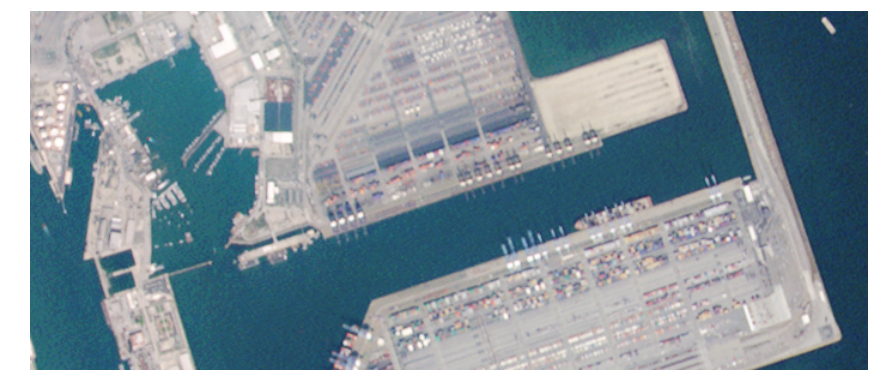

20160315_191710_1154610_RapidEye-3_visual.tif


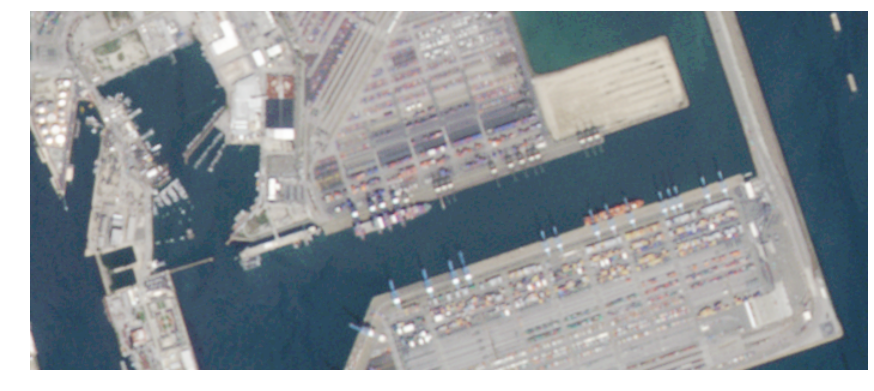

20160316_191802_1154610_RapidEye-4_visual.tif


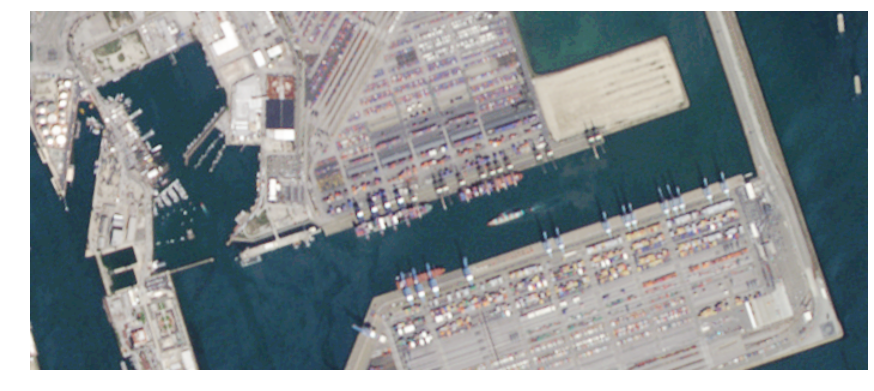

In [7]:
"""
Clip each geotif in a directory to a box

"""

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

def render(arr1, arr2=None, width=7, height=7, cmap=plt.cm.jet):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1, cmap=cmap)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2, cmap=cmap)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')

def clip_image(box, filepath):
    img = mpimg.imread(filepath)
    return img[box[0][0]:box[0][1], box[1][0]:box[1][1], :]

def clip_directory(data_dir, px_box):
    files = os.listdir(data_dir)
    return [clip_image(px_box, os.path.join( data_dir, f )) for f in files]


# a box in pixels coordinates to clip the image to 
px_box = [[2100, 2400], [500, 1200]]

# the directory to open images from 
# every image in the dir will be opened and clipped 
data_dir = './la_images/visual'

images = clip_directory(data_dir, px_box)

files = os.listdir(data_dir)
for i, img in enumerate(images):
    print files[i]
    render(img, width=15, height=15)

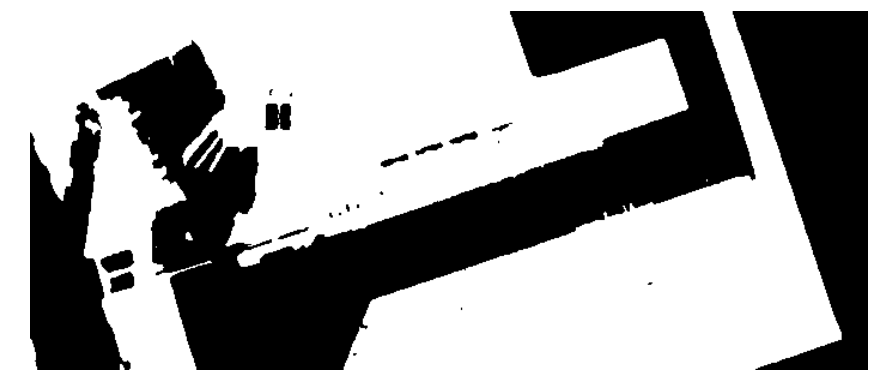

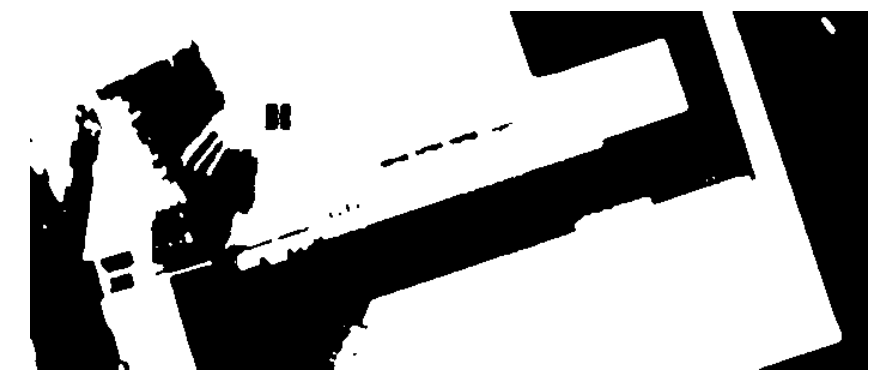

In [52]:
import cv2
from scipy import ndimage

normalize = lambda x: (255 / (x.max() - x.min())) * (x - x.min())
smooth = lambda x: ndimage.convolve(x, np.ones([3,3])/9)

def threshold_mask(img, threshold=100):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.ones(gray.shape).astype(np.uint8)
    mask[gray < threshold] = 0
    return mask

def saturation_mask(img, threshold=170):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    normS = ndimage.convolve(~smooth(gray[:,:,1]), np.ones([3,3])/9)
    mask = normS > threshold
    return mask.astype(np.uint8)

water_mask = reduce( lambda s,e: s & e, [saturation_mask(img) for img in images] )
img_mask = saturation_mask(images[0])

render(water_mask, width=15, height=15, cmap=plt.cm.gray)
render(img_mask, width=15, height=15, cmap=plt.cm.gray)


MSE: 242.373118519
SSIM: 0.513263436035


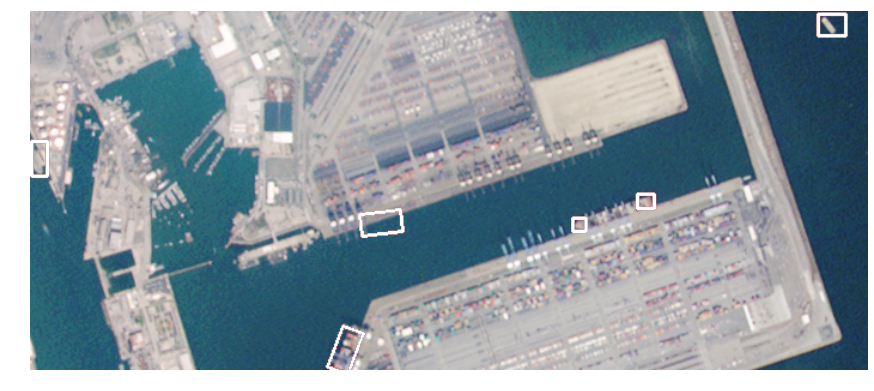

MSE: 91.843478836
SSIM: 0.670991245779


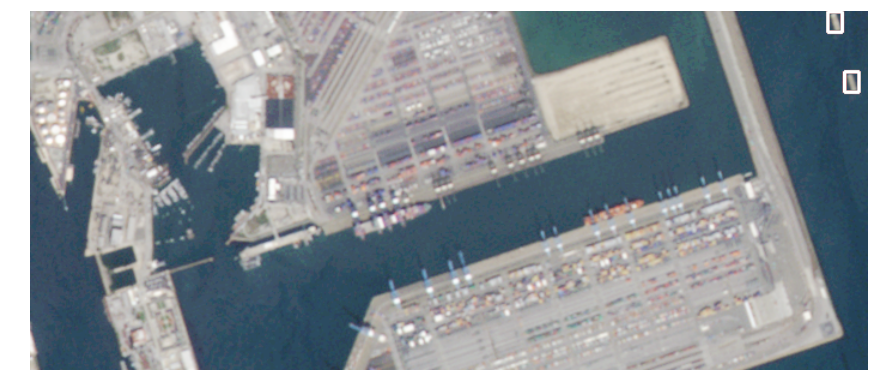

MSE: 162.309789947
SSIM: 0.664336825138


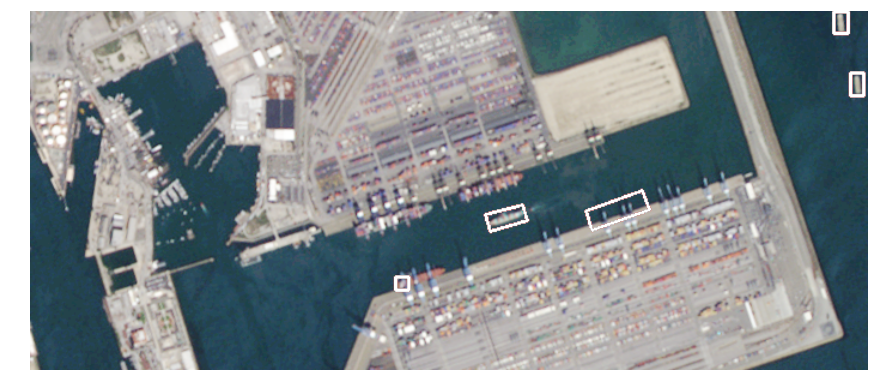

In [56]:
"""
Perform basic change detection on a set of images.
Images are expected to be an list of numpy array (read from tifs on disk)

"""

import cv2
from skimage.measure import compare_ssim as ssim

def average_image(images):
    greys = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    return np.average( np.dstack( greys ), axis=2), greys
    
def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img2.shape[0] * img2.shape[1])
    return err

def create_mask(img, threshold=60):
    mask = np.ones(img.shape).astype(np.uint8)
    mask[np.abs(img) < threshold] = 0
    mask = cv2.filter2D(mask, -1, np.ones((5,5),np.float32)/25)
    mask = cv2.dilate(mask, kernel=np.ones([5, 5]), iterations=2)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel=np.ones([3, 3]), iterations=1)
    return mask

def compare(images, water_mask): 
    avg_image, greys = average_image(images)
    diffs = [(grey - avg_image) for grey in greys]
    
    for i, img in enumerate(diffs):
        print 'MSE:', mse(avg_image, greys[i].astype(np.float64))
        print 'SSIM:', ssim(avg_image, greys[i].astype(np.float64))
        mask = create_mask(img)
        contours, hierarchy = cv2.findContours( mask, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        vis = images[i].copy()
        for i, cnt in enumerate(contours):
            if cv2.contourArea(cnt) > 100.0:
                rect = cv2.minAreaRect(cnt)
                box = cv2.cv.BoxPoints(rect)
                box = np.int0(box)
                cv2.drawContours(vis,[box],0,(255,0,0),2)

        render(vis, width=15, height=15)
    
compare(images, water_mask)